In [1]:
path_15_original = "../eval_outputs/triviaqa_Qwen2.5-1.5B-Instruct_validation_None_threshold.tsv"
path_15_trained = "../eval_outputs/triviaqa_qwen1.5-prompt2_iter300_validation_None_threshold.tsv"

path_3_original = "../eval_outputs/triviaqa_Qwen2.5-3B-Instruct_validation_None_threshold.tsv"
path_3_trained = "../eval_outputs/triviaqa_qwen3-prompt2_iter300_validation_None_threshold.tsv"

path_7_original = "../eval_outputs/triviaqa_Qwen2.5-7B-Instruct_validation_None_threshold.tsv"
path_7_trained = "../eval_outputs/triviaqa_qwen7-prompt2_iter300_validation_None_threshold.tsv"

In [2]:
import matplotlib
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

df = pd.read_csv(path_15_trained, sep="\t")
# df.head()

In [3]:
correctness = df["direct_correctness"]
confidence = df["confidence"]

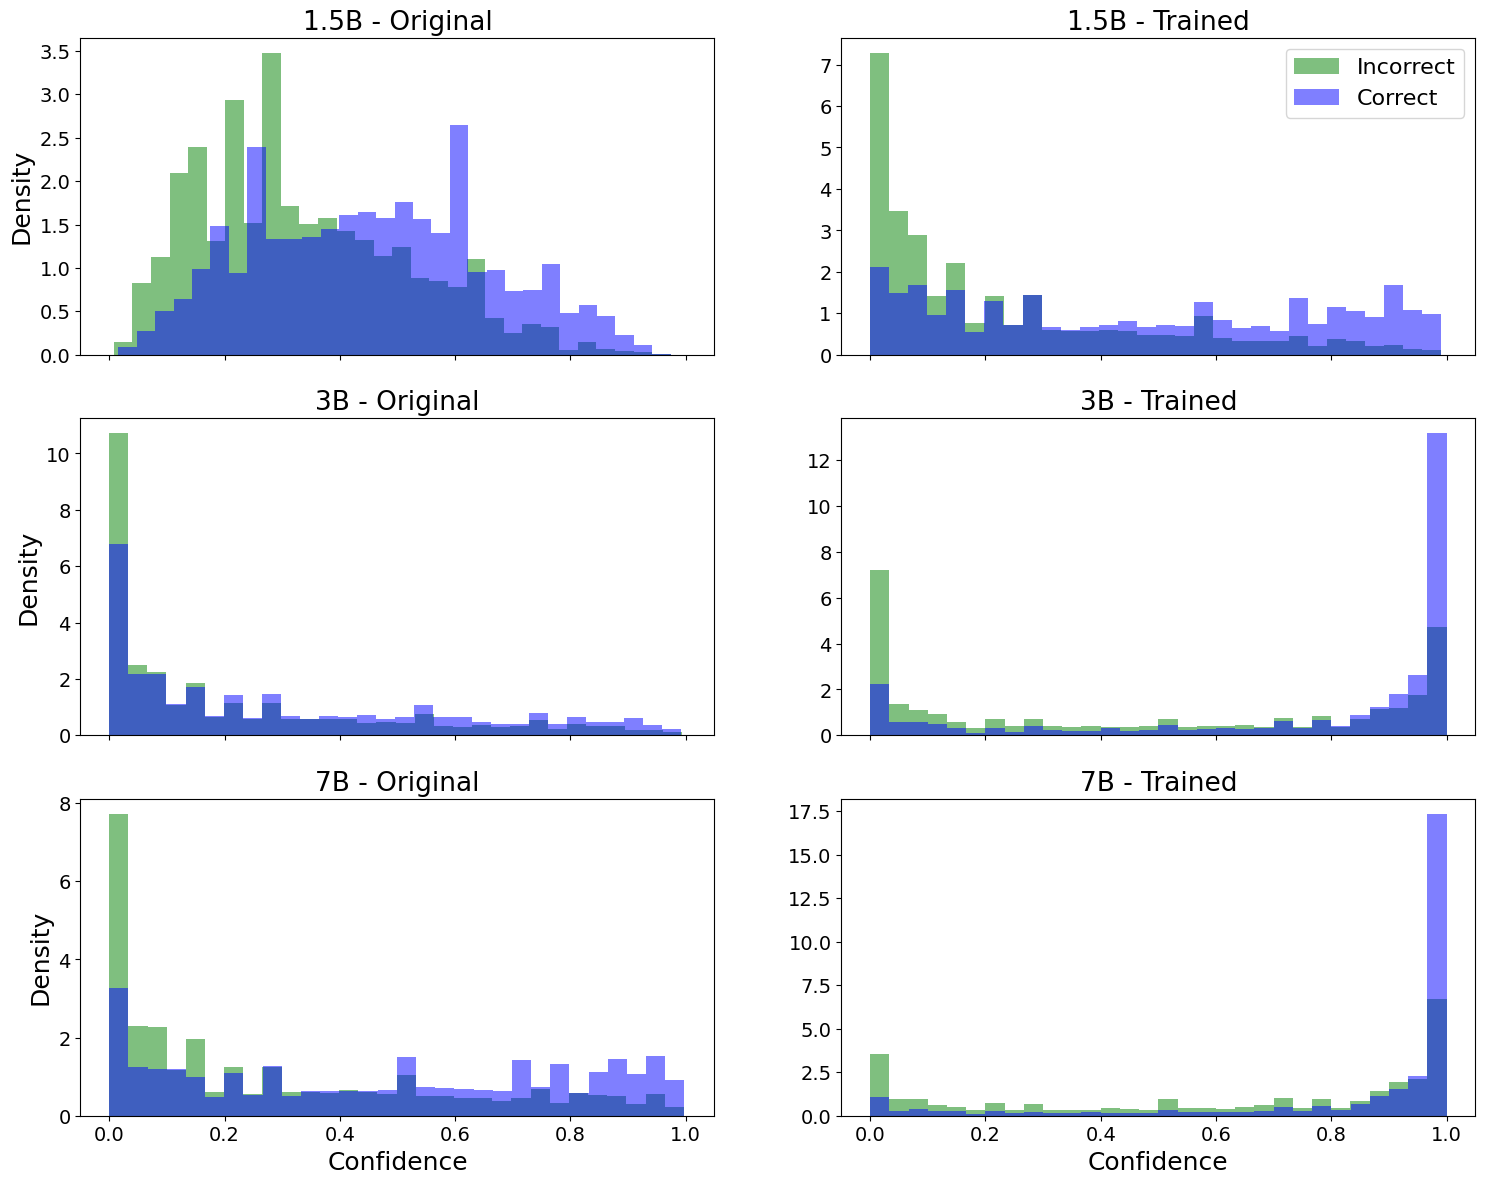

In [4]:
import matplotlib.pyplot as plt

# To plot 6 subplots:
# Row 1: 1.5B (left=original, right=trained)
# Row 2: 3B
# Row 3: 7B

model_info = [
    ("1.5B", path_15_original, path_15_trained),
    ("3B", path_3_original, path_3_trained),
    ("7B", path_7_original, path_7_trained),
]

fig, axes = plt.subplots(3, 2, figsize=(18, 14), sharex=True)

for row, (model_name, original_path, trained_path) in enumerate(model_info):
    for col, (version, path) in enumerate([('Original', original_path), ('Trained', trained_path)]):
        df_tmp = pd.read_csv(path, sep="\t")
        correctness = df_tmp["direct_correctness"]
        confidence = df_tmp["confidence"]
        correct_conf = confidence[correctness == 1]
        incorrect_conf = confidence[correctness == 0]

        ax = axes[row, col]
        ax.hist(
            incorrect_conf,
            bins=30,
            alpha=0.5,
            label='Incorrect',
            color='green',
            density=True,
            histtype='bar',
        )
        ax.hist(
            correct_conf,
            bins=30,
            alpha=0.5,
            label='Correct',
            color='blue',
            density=True,
            histtype='bar',
        )
        if col == 0:
            ax.set_ylabel(f"Density", fontsize=18)
        if row == 2:
            ax.set_xlabel('Confidence', fontsize=18)
        ax.set_title(f"{model_name} - {version}", fontsize=19)
        ax.tick_params(axis='both', which='major', labelsize=14)
        if row == 0 and col == 1:
            legend = ax.legend(loc='upper right', fontsize=16)
        else:
            # Don't show legend except for the specified plot
            ax.legend([],[], frameon=False)

# plt.suptitle('Confidence Distribution by Correctness', fontsize=22, y=0.93)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/confidence-distribution.pdf', dpi=300, transparent=True, bbox_inches='tight', format='pdf')
plt.show()


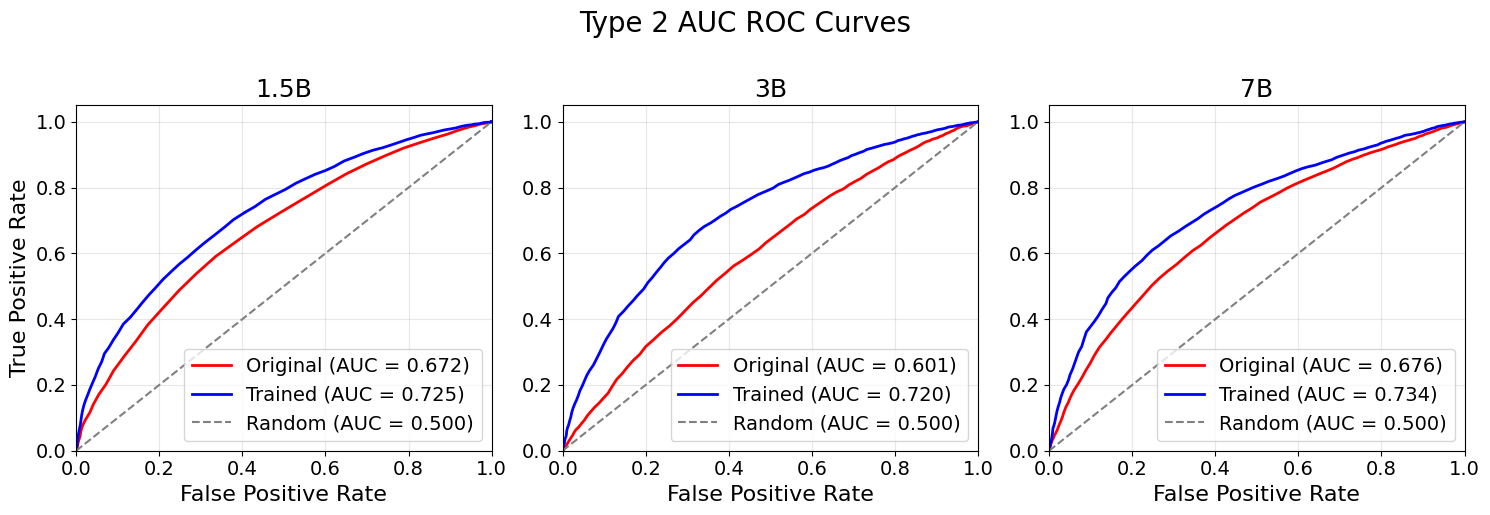

In [19]:
from sklearn.metrics import roc_curve, auc

# To plot 3 subplots horizontally for Type 2 AUC ROC curves:
# Each subplot shows both original and trained models overlaid

model_info = [
    ("1.5B", path_15_original, path_15_trained),
    ("3B", path_3_original, path_3_trained),
    ("7B", path_7_original, path_7_trained),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for col, (model_name, original_path, trained_path) in enumerate(model_info):
    ax = axes[col]

    # Plot original model
    df_original = pd.read_csv(original_path, sep="\t")
    correctness_orig = df_original["direct_correctness"]
    confidence_orig = df_original["confidence"]
    fpr_orig, tpr_orig, _ = roc_curve(correctness_orig, confidence_orig)
    roc_auc_orig = auc(fpr_orig, tpr_orig)
    ax.plot(fpr_orig, tpr_orig, color='red', lw=2, label=f'Original (AUC = {roc_auc_orig:.3f})')

    # Plot trained model
    df_trained = pd.read_csv(trained_path, sep="\t")
    correctness_train = df_trained["direct_correctness"]
    confidence_train = df_trained["confidence"]
    fpr_train, tpr_train, _ = roc_curve(correctness_train, confidence_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    ax.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Trained (AUC = {roc_auc_train:.3f})')

    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random (AUC = 0.500)')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=16)
    if col == 0:
        ax.set_ylabel('True Positive Rate', fontsize=16)
    ax.set_title(f"{model_name}", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=14)

plt.suptitle('Type 2 AUC ROC Curves', fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('figures/type2-auc-roc.pdf', dpi=300, transparent=True, bbox_inches='tight', format='pdf')
plt.show()
